In [1]:
import wrangle as w
import explore as e
import wrangle_Naomi
import env

import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

from importlib import reload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
reload(w)
df = w.wrangle_zillow()

In [3]:
df.shape

(77375, 19)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77375 entries, 0 to 77374
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   parcel_id               77375 non-null  int64   
 1   bath_count              77375 non-null  float64 
 2   bed_count               77375 non-null  float64 
 3   calc_bath_and_bed       77375 non-null  float64 
 4   calc_sqft               77375 non-null  float64 
 5   fips                    77375 non-null  category
 6   fireplace_count         77375 non-null  float64 
 7   garage_car_count        77375 non-null  float64 
 8   latitude                77375 non-null  float64 
 9   longitude               77375 non-null  float64 
 10  lot_sqft                77375 non-null  float64 
 11  pool_count              77375 non-null  float64 
 12  raw_census_tract_block  77375 non-null  float64 
 13  region_id_county        77375 non-null  float64 
 14  room_count            

In [5]:
train, validate, test = w.tvt_split(df)

In [6]:
print("train observations: ", train.shape)
print("validate observations: ", validate.shape)
print("test observations: ", test.shape)

train observations:  (43330, 19)
validate observations:  (18570, 19)
test observations:  (15475, 19)


In [7]:
train.log_error.isnull().sum()

0

# explore

### Does having nice outdoor features have a relationship with logerror?

### Unscaled

In [8]:
train.head()

,parcel_id,bath_count,bed_count,calc_bath_and_bed,calc_sqft,fips,fireplace_count,garage_car_count,latitude,longitude,lot_sqft,pool_count,raw_census_tract_block,region_id_county,room_count,tax_value,assessment_year,log_error,transaction_date
73693,12021842,4.0,3.0,4.0,3547.0,6037.0,0.0,0.0,34094724.0,-118387946.0,17285.0,1.0,6.037194e+07,3101.0,0.0,2321157.0,2016.0,-0.009462,1504656000000000000
21575,12680293,2.0,3.0,2.0,1416.0,6037.0,0.0,0.0,33820048.0,-118358634.0,5039.0,0.0,6.037651e+07,3101.0,0.0,561559.0,2016.0,-0.015706,1490832000000000000
38043,11536920,3.0,5.0,3.0,2499.0,6037.0,0.0,0.0,33986221.0,-118457170.0,3600.0,0.0,6.037274e+07,3101.0,0.0,377349.0,2016.0,0.046132,1495411200000000000
39804,14130577,1.0,2.0,1.0,896.0,6059.0,0.0,1.0,33843241.0,-117942823.0,1863.0,0.0,6.059087e+07,1286.0,5.0,274415.0,2016.0,-0.003631,1495756800000000000
8246,11203234,2.0,3.0,2.0,1432.0,6037.0,0.0,0.0,34565472.0,-118075987.0,6294.0,0.0,6.037911e+07,3101.0,0.0,92132.0,2016.0,-0.003082,1486425600000000000


In [9]:
X3 = train[['garage_car_count', 'pool_count', 'lot_sqft']]

In [10]:
kmeans = KMeans(n_clusters = 4, random_state= 89).fit(X3)
train['cluster3'] = kmeans.predict(X3)

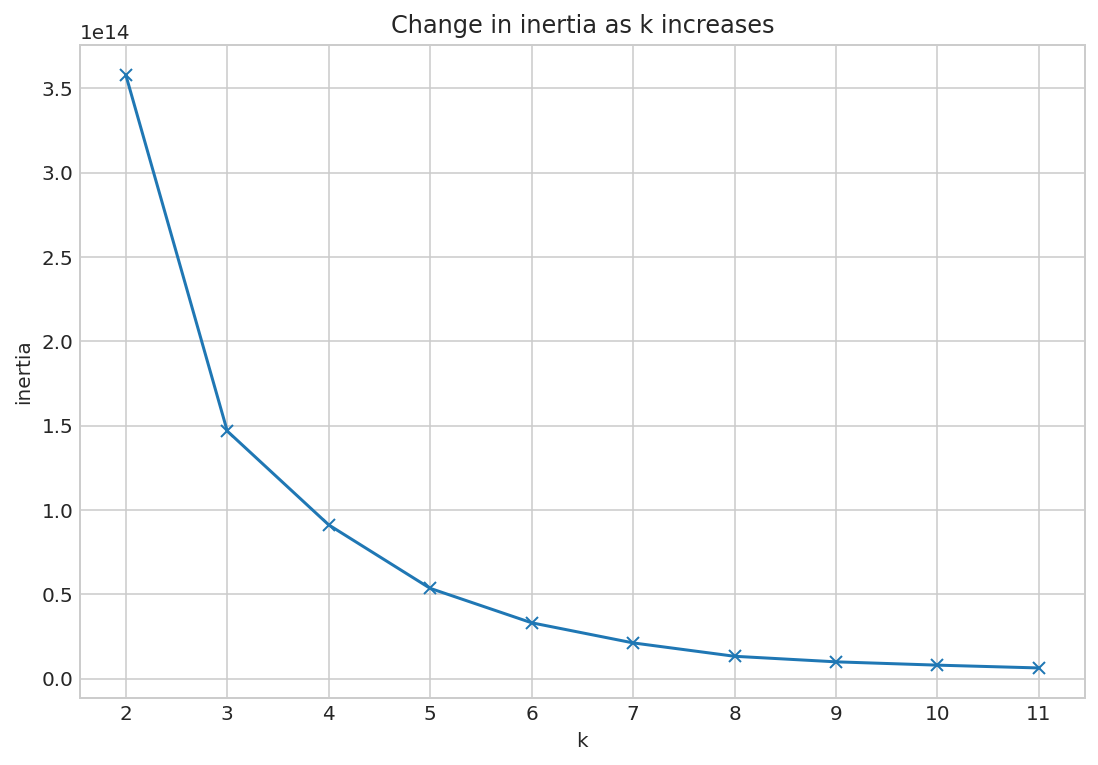

In [11]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [12]:
train.groupby('cluster3')['garage_car_count', 'pool_count', 'lot_sqft'].mean()

,garage_car_count,pool_count,lot_sqft
cluster3,,,
0,0.621456,0.196853,1.239236e+04
1,0.000000,0.000000,5.126356e+06
2,0.000000,0.426752,9.967749e+05
3,0.014905,0.528455,3.002159e+05


<AxesSubplot:xlabel='cluster3', ylabel='log_error'>

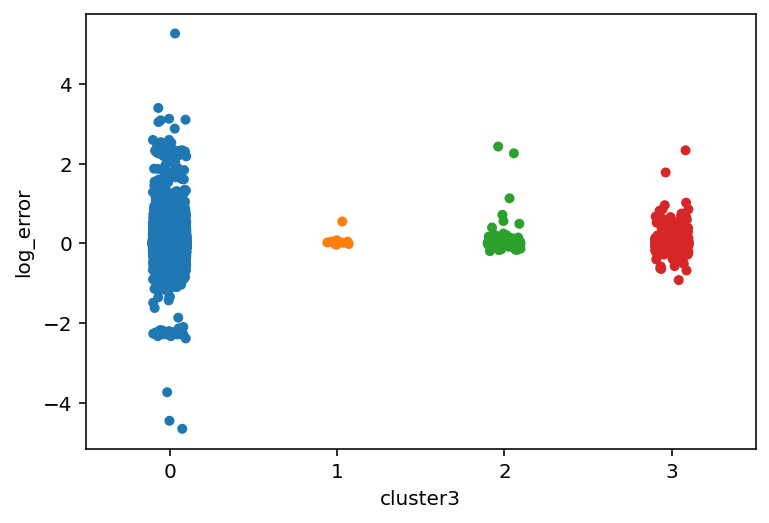

In [13]:
sns.stripplot(data = train, x = 'cluster3', y = 'log_error')

### Scaled

In [14]:
train_scaled3 = w.scale(train, ['garage_car_count', 'pool_count', 'lot_sqft'])
train_scaled3.head()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft
73693,0.000000,1.0,0.002480
21575,0.000000,0.0,0.000723
38043,0.000000,0.0,0.000516
39804,0.090909,0.0,0.000267
8246,0.000000,0.0,0.000903


In [15]:
extracted_col = train['log_error']

In [16]:
X3_scaled = train_scaled3[['scaled_garage_car_count', 'scaled_pool_count', 'scaled_lot_sqft']]

In [17]:
X3_scaled.head()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft
73693,0.000000,1.0,0.002480
21575,0.000000,0.0,0.000723
38043,0.000000,0.0,0.000516
39804,0.090909,0.0,0.000267
8246,0.000000,0.0,0.000903


In [18]:
kmeans = KMeans(n_clusters = 4, random_state = 89).fit(X3_scaled)
train_scaled3['cluster3_scaled'] = kmeans.predict(X3_scaled)

In [19]:
train_scaled3['log_error'] = train['log_error']

In [20]:
train_scaled3.head()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft,cluster3_scaled,log_error
73693,0.000000,1.0,0.002480,0,-0.009462
21575,0.000000,0.0,0.000723,1,-0.015706
38043,0.000000,0.0,0.000516,1,0.046132
39804,0.090909,0.0,0.000267,2,-0.003631
8246,0.000000,0.0,0.000903,1,-0.003082


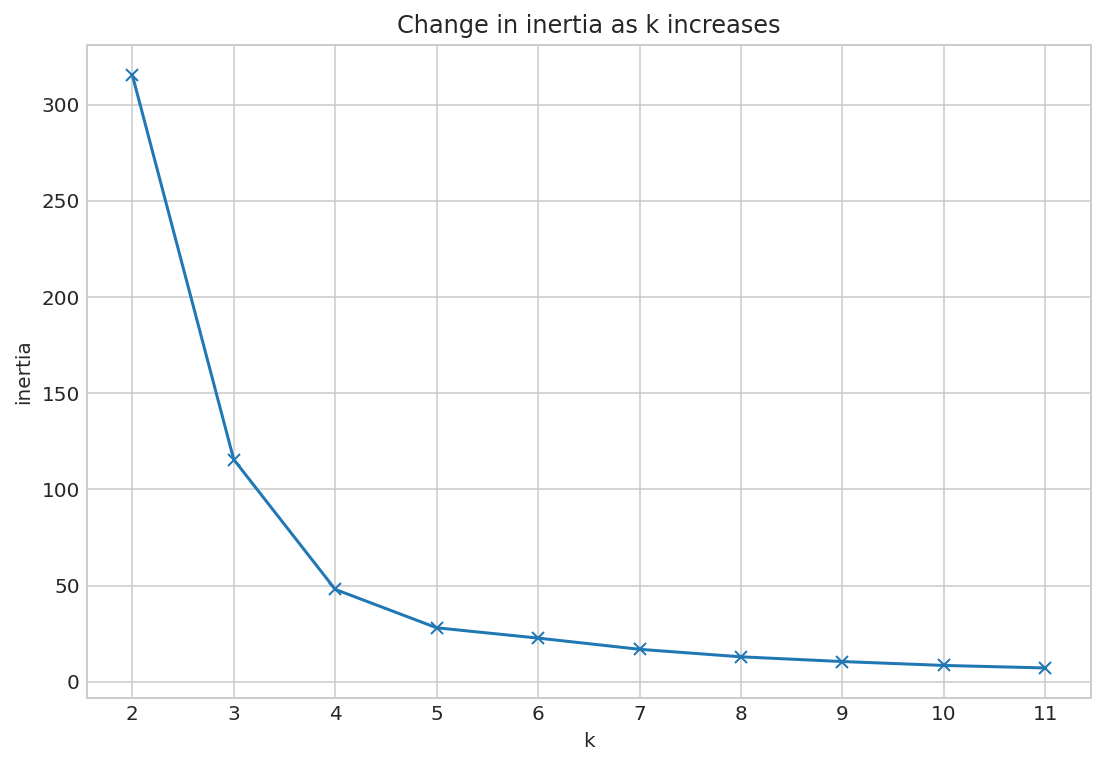

In [21]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [22]:
train_scaled3.groupby('cluster3_scaled')['scaled_garage_car_count', 'scaled_pool_count', 'scaled_lot_sqft'].mean()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft
cluster3_scaled,,,
0,0.002582,1.0,0.009674
1,0.000000,0.0,0.003989
2,0.161209,0.0,0.000716
3,0.201007,1.0,0.001840


In [23]:
train_scaled3.head()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft,cluster3_scaled,log_error
73693,0.000000,1.0,0.002480,0,-0.009462
21575,0.000000,0.0,0.000723,1,-0.015706
38043,0.000000,0.0,0.000516,1,0.046132
39804,0.090909,0.0,0.000267,2,-0.003631
8246,0.000000,0.0,0.000903,1,-0.003082


<AxesSubplot:xlabel='cluster3_scaled', ylabel='log_error'>

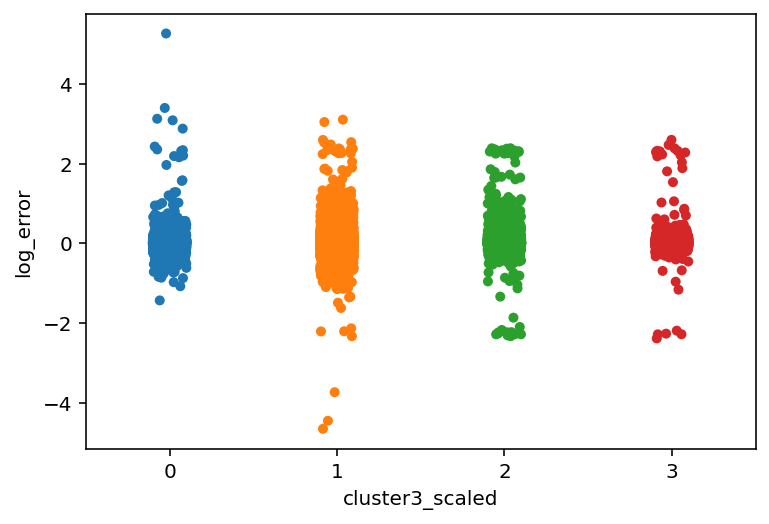

In [24]:
sns.stripplot(data = train_scaled3, x = 'cluster3_scaled', y = 'log_error')

Text(0.5, 1.0, 'Scaled')

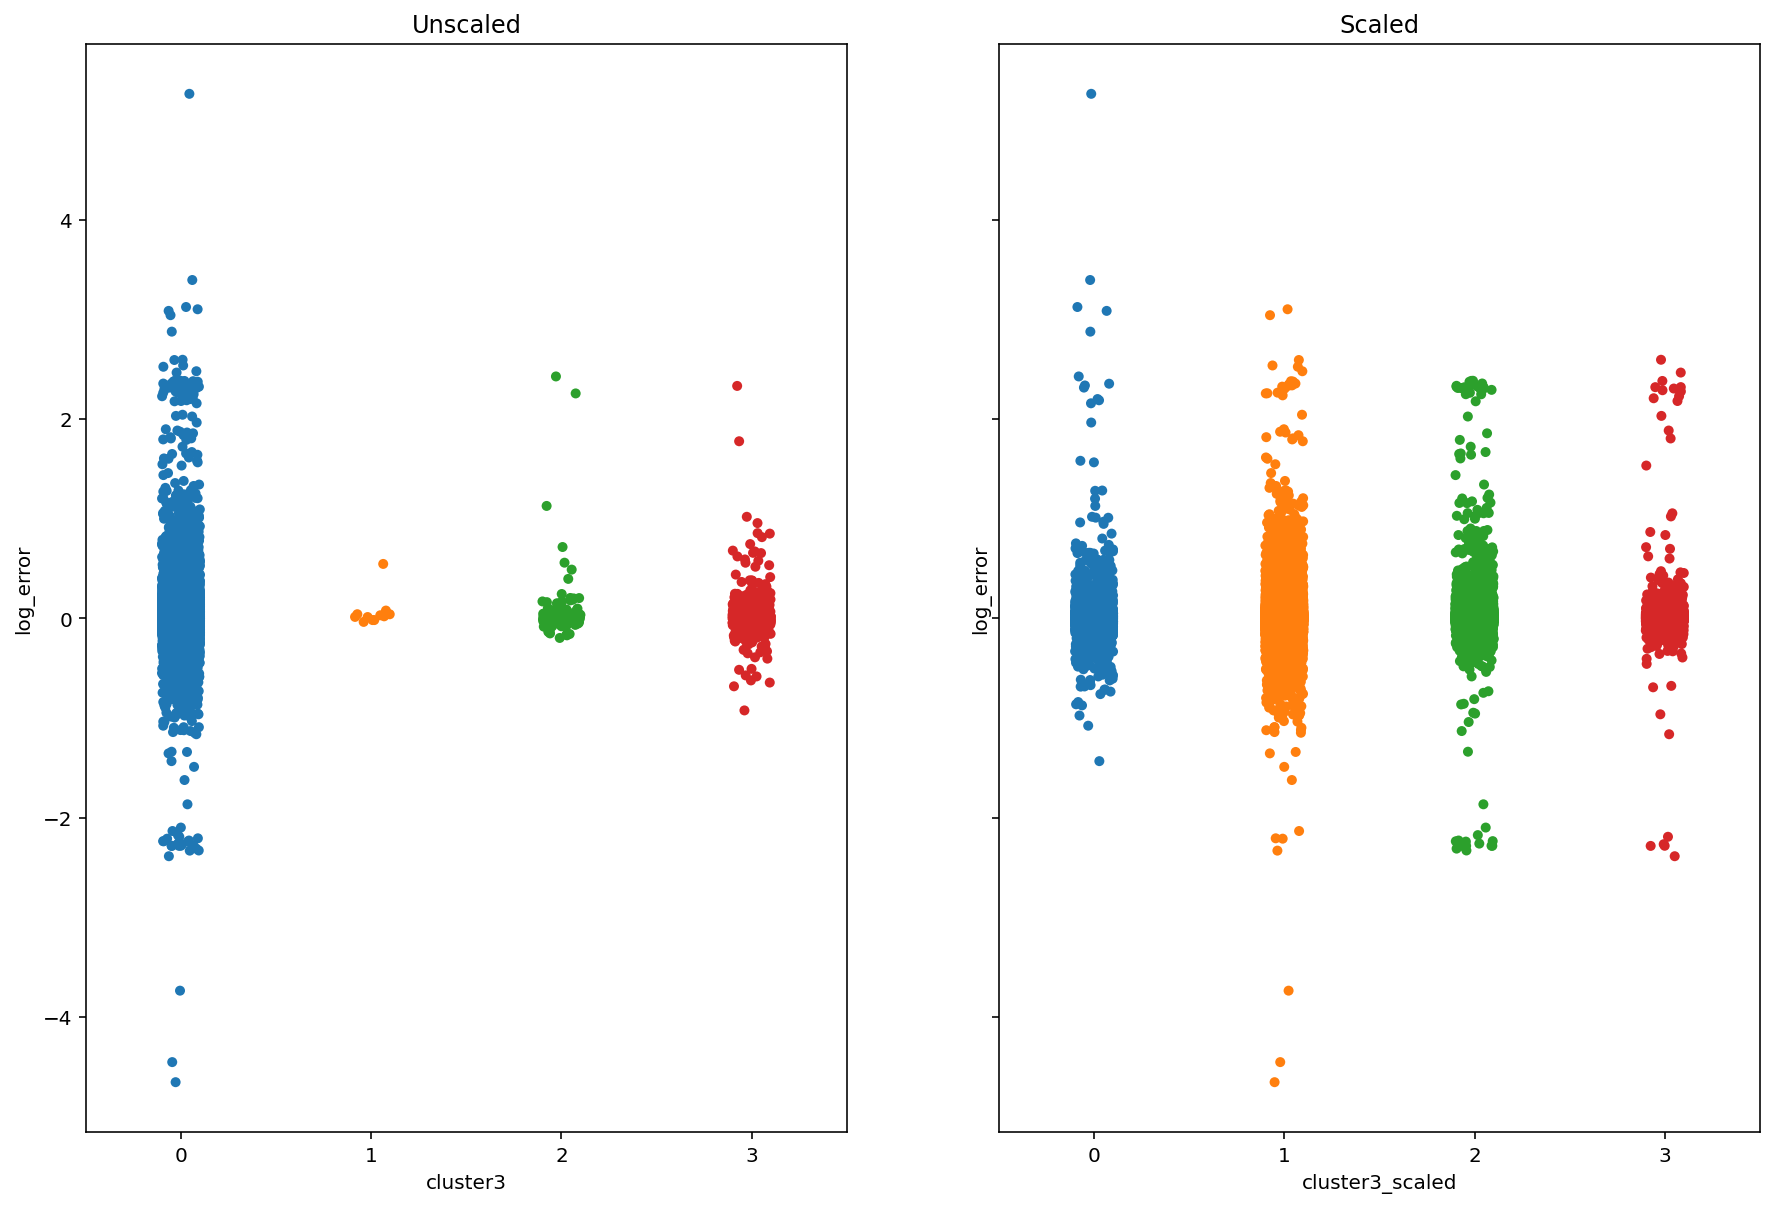

In [25]:
fig, axes= plt.subplots(1,2, figsize =(15, 10), sharey = True)
fig.subtitle = ('Unscaled vs. Scaled')

#Unscaled
sns.stripplot(ax=axes[0], data = train, x = 'cluster3', y = 'log_error')
axes[0].set_title('Unscaled')

#Scaled
sns.stripplot(ax = axes[1],data = train_scaled3, x = 'cluster3_scaled', y = 'log_error')
axes[1].set_title('Scaled')

In [26]:
def viz_for_Q3(train_df):
    
    #unscaled data
    X3 = train[['garage_car_count', 'pool_count', 'lot_sqft']]
    kmeans = KMeans(n_clusters = 4, random_state = 89).fit(X3)
    train['cluster3'] = kmeans.predict(X3)
    
    #scaled data
    train_scaled3 = w.scale(train, ['garage_car_count', 'pool_count', 'lot_sqft'])
    X3_scaled = train_scaled3[['scaled_garage_car_count', 'scaled_pool_count', 'scaled_lot_sqft']]
    kmeans = KMeans(n_clusters = 4, random_state = 89).fit(X3_scaled)
    train_scaled3['cluster3_scaled'] = kmeans.predict(X3_scaled)
    train_scaled3['log_error'] = train['log_error']
    
    #viz 
    fig, axes= plt.subplots(1,2, figsize =(15, 10), sharey = True)
    fig.subtitle = ('Unscaled vs. Scaled')

    #Unscaled
    sns.stripplot(ax=axes[0], data = train, x = 'cluster3', y = 'log_error')
    axes[0].set_title('Unscaled')

    #Scaled
    sns.stripplot(ax = axes[1],data = train_scaled3, x = 'cluster3_scaled', y = 'log_error')
    axes[1].set_title('Scaled')
    
    plt.show()

In [27]:
X3.head()

,garage_car_count,pool_count,lot_sqft
73693,0.0,1.0,17285.0
21575,0.0,0.0,5039.0
38043,0.0,0.0,3600.0
39804,1.0,0.0,1863.0
8246,0.0,0.0,6294.0


In [28]:
train.head()

,parcel_id,bath_count,bed_count,calc_bath_and_bed,calc_sqft,fips,fireplace_count,garage_car_count,latitude,longitude,lot_sqft,pool_count,raw_census_tract_block,region_id_county,room_count,tax_value,assessment_year,log_error,transaction_date,cluster3
73693,12021842,4.0,3.0,4.0,3547.0,6037.0,0.0,0.0,34094724.0,-118387946.0,17285.0,1.0,6.037194e+07,3101.0,0.0,2321157.0,2016.0,-0.009462,1504656000000000000,0
21575,12680293,2.0,3.0,2.0,1416.0,6037.0,0.0,0.0,33820048.0,-118358634.0,5039.0,0.0,6.037651e+07,3101.0,0.0,561559.0,2016.0,-0.015706,1490832000000000000,0
38043,11536920,3.0,5.0,3.0,2499.0,6037.0,0.0,0.0,33986221.0,-118457170.0,3600.0,0.0,6.037274e+07,3101.0,0.0,377349.0,2016.0,0.046132,1495411200000000000,0
39804,14130577,1.0,2.0,1.0,896.0,6059.0,0.0,1.0,33843241.0,-117942823.0,1863.0,0.0,6.059087e+07,1286.0,5.0,274415.0,2016.0,-0.003631,1495756800000000000,0
8246,11203234,2.0,3.0,2.0,1432.0,6037.0,0.0,0.0,34565472.0,-118075987.0,6294.0,0.0,6.037911e+07,3101.0,0.0,92132.0,2016.0,-0.003082,1486425600000000000,0


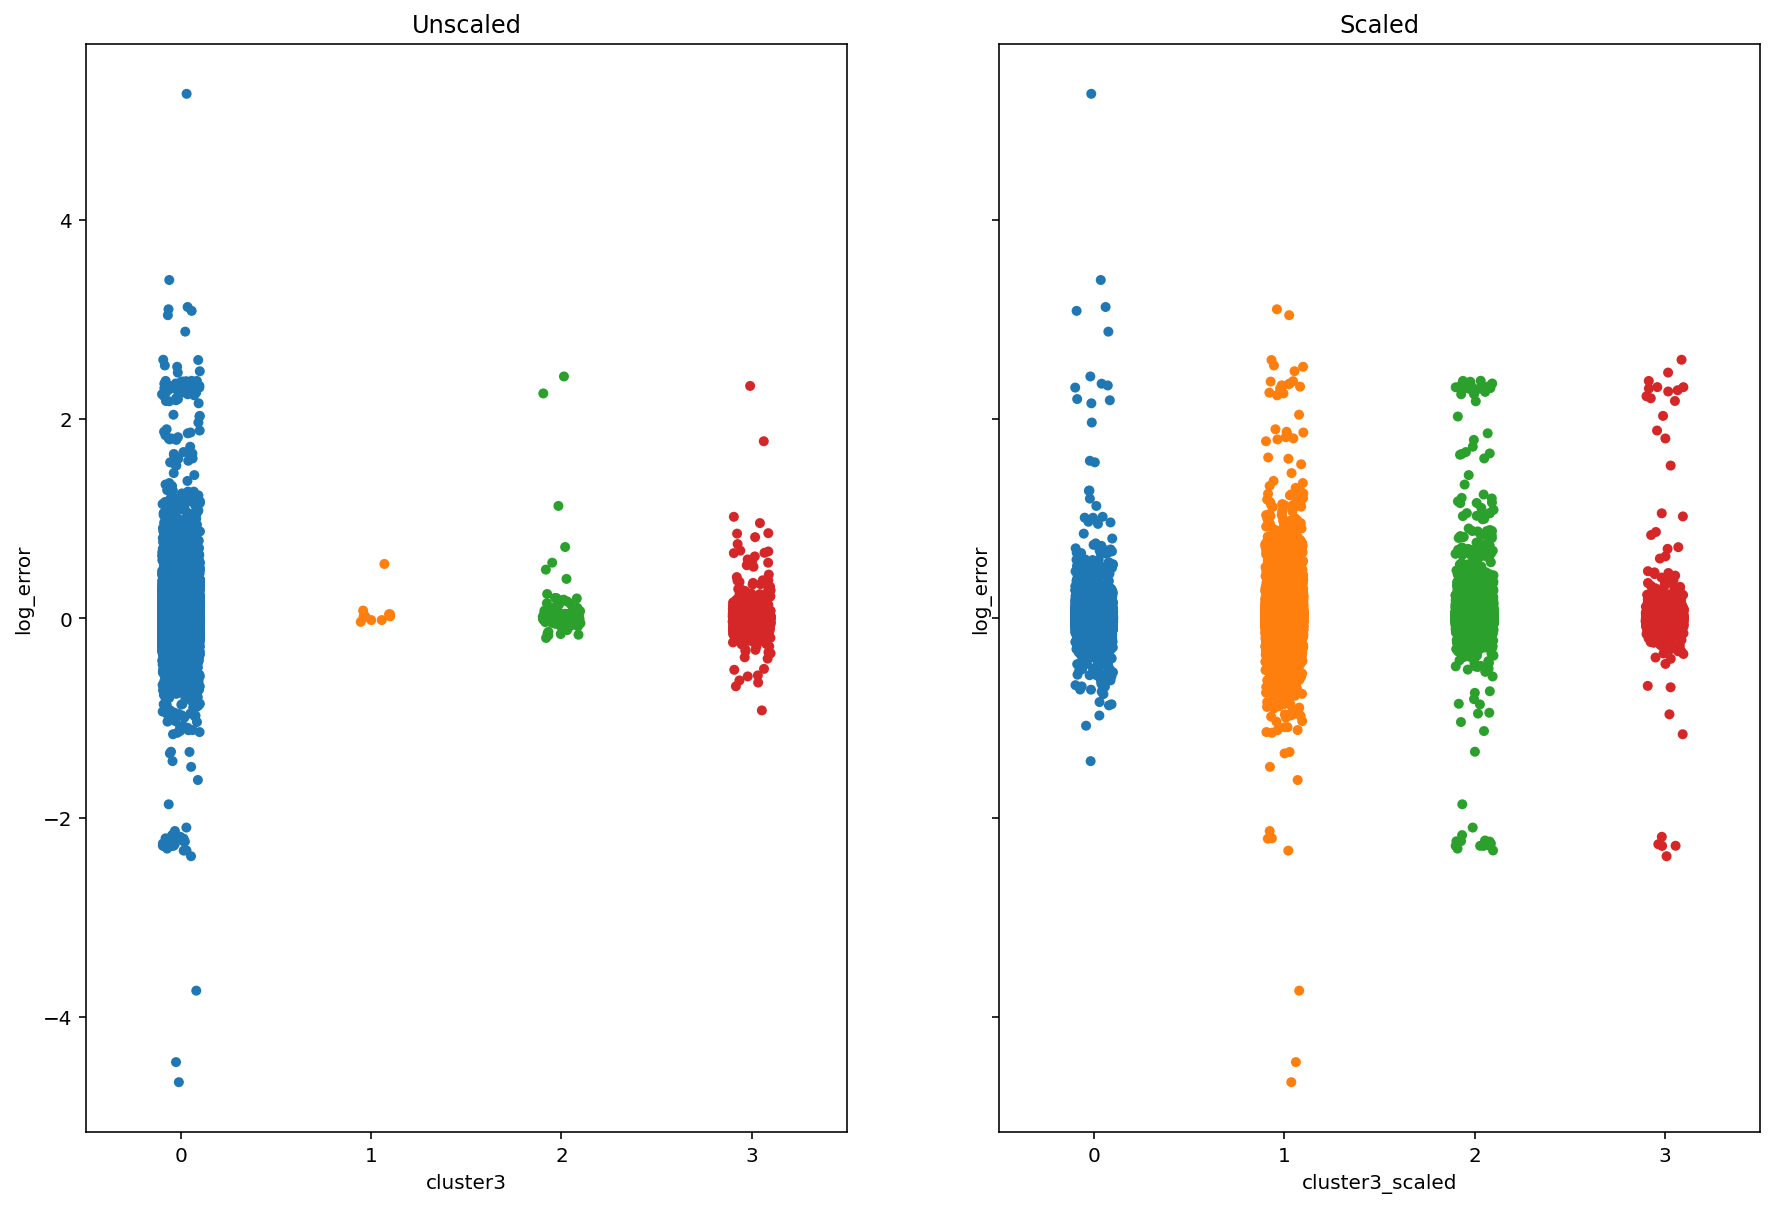

In [29]:
viz_for_Q3(df)

In [30]:
# need to run a stat test to determine 

In [31]:
def anova_test(df,col):
    group_list = [df[df[col] == x].log_error.to_numpy() for x in range(4)]
    t,p = stats.kruskal(group_list[0],group_list[1],group_list[2],group_list[3])
    return e.t_to_md(t,p)

In [33]:
anova_test(train, 'cluster3')

## t = 0.12168643873344878 

 ## p = 5.801327910069646 

## Because t > 0 and $\alpha$ < p,we failed to  reject $H_0$

In [34]:
anova_test(train_scaled3, 'cluster3_scaled')

## t = 8.296902485164197e-10 

 ## p = 45.22280000852593 

## Because t > 0 and $\alpha$ < p,we failed to  reject $H_0$

### creating and comparing clusters of features

In [ ]:
all_features = train.columns

In [ ]:
cluster_test =train.copy()

In [ ]:
train.columns

In [ ]:
for feature in all_features:
    for feature2 in all_features:
        if feature != feature2: 
            cluster_fun = cluster_test[[feature, feature2]]

            #Fit a new model to my scaled data
            kmeans_scale = KMeans(n_clusters=4, random_state = 89)

            kmeans_scale.fit(cluster_fun)

            cluster_test['cluster_fun'] = kmeans_scale.predict(cluster_fun)
            plt.title(f'{feature} and {feature2} cluster')
            sns.scatterplot(y='log_error', x='cluster_fun',
                    palette='colorblind', data=cluster_test)
            plt.show()

In [ ]:
def viz_for_Q2(train_df):
    
    #unscaled data
    X2 = train_df[['tax_value', 'calc_sqft']]
    kmeans = KMeans(n_clusters = 4, random_state =89).fit(X2)
    train['cluster2'] = kmeans.predict(X2)
    
    #scaled data
    train_scaled2 = w.scale(train, ['tax_value', 'calc_sqft'])
    X2_scaled = train_scaled2[['scaled_tax_value', 'scaled_calc_sqft']]
    kmeans = KMeans(n_clusters = 4, random_state = 89).fit(X2_scaled)
    
    train_scaled2['cluster2_scaled'] = kmeans.predict(X2_scaled)
    train_scaled2['log_error'] = train['log_error']
    
    #viz 
    fig, axes= plt.subplots(1,2, figsize =(15, 10), sharey = True)
    fig.subtitle = ('Unscaled vs. Scaled')

    #Unscaled
    sns.stripplot(ax=axes[0], data = train, x = 'cluster2', y = 'log_error')
    axes[0].set_title('Unscaled')

    #Scaled
    sns.stripplot(ax = axes[1],data = train_scaled2, x = 'cluster2_scaled', y = 'log_error')
    axes[1].set_title('Scaled')
    
    plt.show()

In [ ]:
viz_for_Q2(train)

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.log_error_outliers

In [ ]:
df.transaction_date.min()

In [ ]:
df.head()